## Violin Plots Based on Condition

/tmp/ipykernel_9788/622325212.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='FER', data=df, bw=0.2, cut=0, inner=None, palette='Set2', orient='v')
/tmp/ipykernel_9788/622325212.py:54: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='Condition', y='FER', data=df, bw=0.2, cut=0, inner=None, palette='Set2', orient='v')


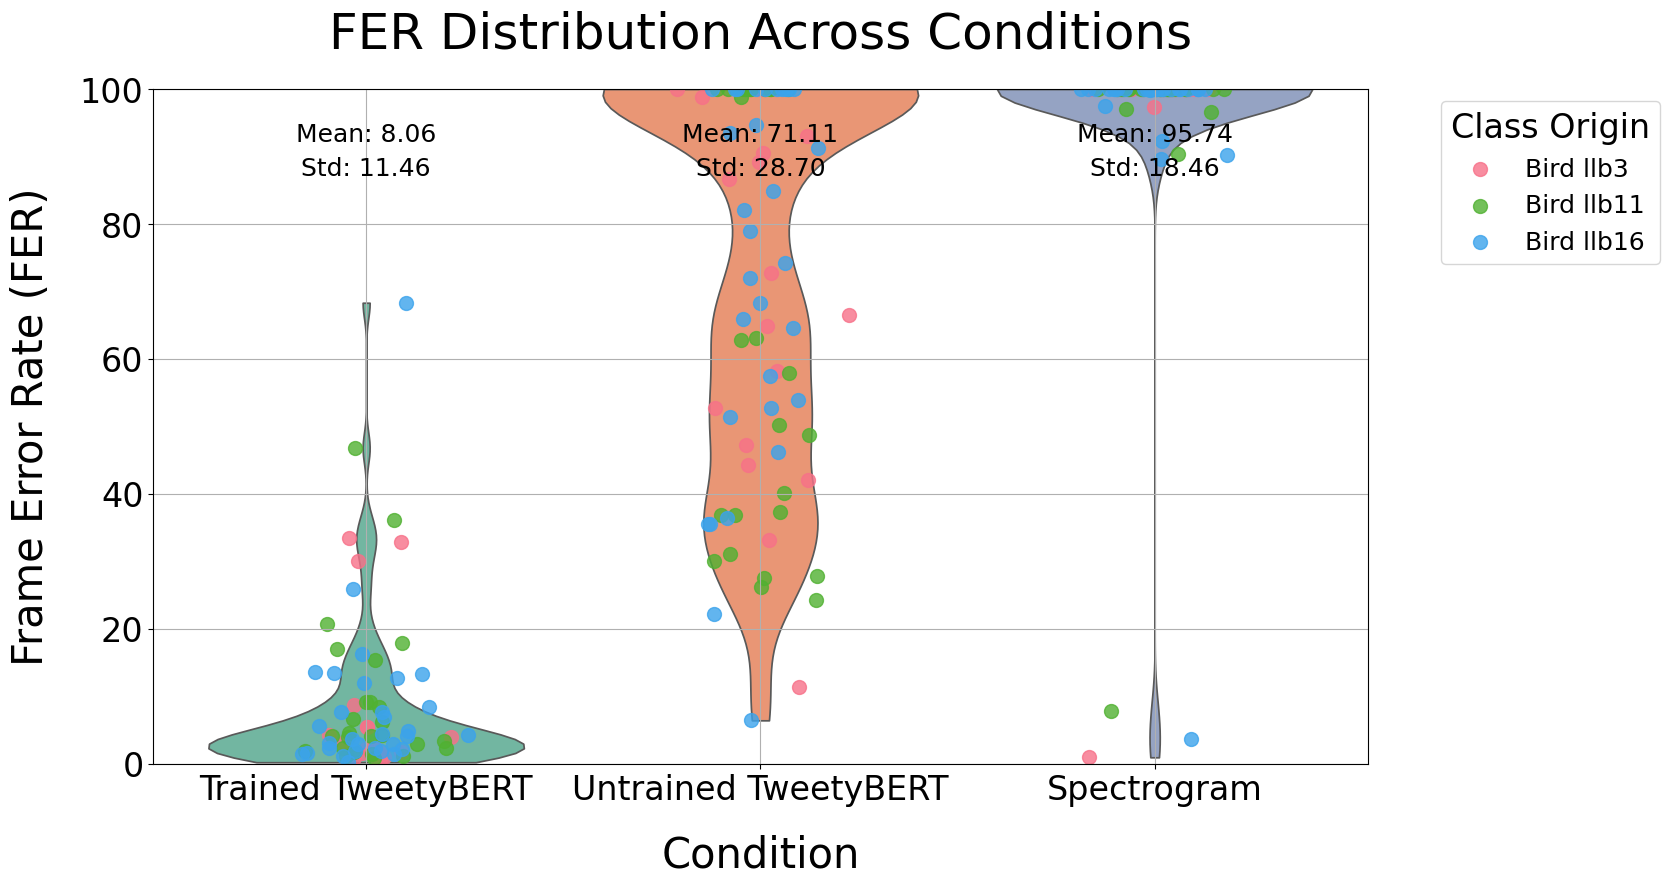

In [2]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Directories for the different conditions
conditions = ['Trained TweetyBERT', 'Untrained TweetyBERT', 'Spectrogram']
base_path = '/home/george-vengrovski/Documents/projects/tweety_bert_paper/results'

# Initialize an empty list to store data
all_data = []

# Load JSON files and aggregate data
for cond in conditions:
    cond_path = os.path.join(base_path, cond)
    for filename in os.listdir(cond_path):
        if filename.endswith('.json'):
            filepath = os.path.join(cond_path, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
                
                # Extract bird_id from filename
                bird_id = filename.split('.')[0]
                
                # Extract class FERs
                class_fer_dict = data.get('class_frame_error_rates', {})
                
                for class_label, fer in class_fer_dict.items():
                    all_data.append({
                        'Condition': cond,
                        'Class': class_label,
                        'FER': fer,
                        'Bird ID': bird_id
                    })

# Convert list of dictionaries to a DataFrame
df = pd.DataFrame(all_data)

# Ensure that 'Condition' is a categorical variable for better plotting
df['Condition'] = pd.Categorical(df['Condition'], categories=conditions)

# Sort data by Class for better visualization
df = df.sort_values(by=['Class'])

# Adjust plot settings for better spacing
plt.rcParams.update({'font.size': 24})  # Decrease overall font size

# Plot the violin plot with overlaid dot plots
plt.figure(figsize=(20, 12))

# Violin plot with different colors for each condition
sns.violinplot(x='Condition', y='FER', data=df, bw=0.2, cut=0, inner=None, palette='Set2', orient='v')

# Set y-axis limit to 100
plt.ylim(0, 100)

# Overlay scatter plot
bird_ids = df['Bird ID'].unique()
colors = sns.color_palette('husl', len(bird_ids))  # Generate different colors for bird IDs

for i, cond in enumerate(conditions):
    condition_data = df[df['Condition'] == cond]
    
    for j, bird_id in enumerate(bird_ids):
        bird_data = condition_data[condition_data['Bird ID'] == bird_id]
        # Scatter plot for each bird ID within the condition with increased dot size
        plt.scatter(np.random.normal(i, 0.08, size=len(bird_data)), bird_data['FER'], 
                    color=colors[j], alpha=0.8, s=100, label=f'Bird {bird_id}' if i == 0 else "")

    # Calculate statistics for annotation
    mean = condition_data['FER'].mean()  # Changed from median to mean
    std_dev = condition_data['FER'].std()

    # Annotate the plot above the violin plot but within the border
    plt.text(i, 95, f'Mean: {mean:.2f}',  # Changed label from 'Median' to 'Mean'
             ha='center', va='top', fontsize=18, color='black')  # Positioned near the top
    plt.text(i, 90, f'Std: {std_dev:.2f}', 
             ha='center', va='top', fontsize=18, color='black')  # Positioned slightly lower

# Set x-axis labels horizontal
plt.xticks(ticks=np.arange(len(conditions)), labels=conditions, rotation=0, fontsize=24)
plt.title('FER Distribution Across Conditions', fontsize=36, pad=30)
plt.xlabel('Condition', fontsize=30, labelpad=20)
plt.ylabel('Frame Error Rate (FER)', fontsize=30, labelpad=20)
plt.legend(title='Class Origin', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, title_fontsize=24)
plt.grid(True)
plt.tight_layout(pad=5)

# Save plot if needed
# plt.savefig('fer_violin_plot_annotations_fixed.png', dpi=300)

plt.show()


## Layer Wise FER

In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Directory containing folders with JSON files
base_dir = '/home/george-vengrovski/Documents/projects/tweety_bert_paper/results/layer_Wise_test'

# Initialize lists to store data for plotting
layers = []
average_fer = []
std_fer = []

# Get all subdirectories in the base directory
subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Function to extract layer number from filename
def get_layer_number(filename):
    return int(filename.split('_')[1])

# Process each layer across all subdirectories
for layer_file in sorted(os.listdir(os.path.join(base_dir, subdirs[0])), key=get_layer_number):
    if layer_file.endswith('.json'):
        layer_name = layer_file.split('.')[0]
        layer_total_fer = []
        layer_class_fers = []

        for subdir in subdirs:
            filepath = os.path.join(base_dir, subdir, layer_file)
            with open(filepath, 'r') as file:
                data = json.load(file)
                
                # Extract total FER for this layer and folder
                layer_total_fer.append(data['total_frame_error_rate'])
                
                # Extract class FERs for this layer and folder
                class_fers = list(data['class_frame_error_rates'].values())
                layer_class_fers.extend(class_fers)

        # Compute average total FER and std deviation of class FERs for this layer
        avg_fer = np.mean(layer_total_fer)
        std_dev_fer = np.std(layer_class_fers)
        
        # Store computed values for plotting
        layers.append(layer_name)
        average_fer.append(avg_fer)
        std_fer.append(std_dev_fer)

# Convert to DataFrame for easier handling
df = pd.DataFrame({
    'Layer': layers,
    'Average FER': average_fer,
    'Std Dev FER': std_fer
})

# Sort DataFrame by the layer number
df['Layer_num'] = df['Layer'].apply(lambda x: int(x.split('_')[1]))
df = df.sort_values('Layer_num')

# Plotting the line plot with error bars
plt.figure(figsize=(12, 8))
plt.errorbar(df['Layer'], df['Average FER'], yerr=df['Std Dev FER'], fmt='-o', capsize=5, capthick=2)

plt.title('Average Frame Error Rate (FER) Across Layers', fontsize=12)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Average Frame Error Rate (FER)', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Save plot if needed
# plt.savefig('fer_line_plot_across_layers.png', dpi=300)

plt.show()

IndexError: list index out of range